<a href="https://colab.research.google.com/github/FVaisfeld/ml/blob/main/data_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check for bias between chinese and our data

In this lab, I will check if we need to do some fine tuning or if we can just use the chinese data for training an arrythia model on out data. 



In [ ]:
# Install this package to use Colab's GPU for training
#!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Run the code below to load the dataset `Chinese_Cardisio_Combined.mat` and adjust the format of the data



In [53]:
from scipy import io
import numpy as np
import pandas as pd 

age_temp = io.loadmat('Age.mat')
age = []
[age.append(float(n[0])) for n in age_temp['Age']]
age = np.array(age)


sex_temp = io.loadmat('Sex.mat')
sex = {}
sex = [(str(n[0][0])) for n in sex_temp['Sex']]
sex = np.array(sex)
print(set(sex))


labels_temp = io.loadmat('Labels.mat')
labels = []
[labels.append((n[0][0])) for n in labels_temp['Labels_temp']]
categories = set(labels)
print(str('categories: ' + str(categories)))

#load data Cardisio
cardisio_measurements_temp = io.loadmat('Cardisio_measurements.mat')
cardisio_measurements = []
[cardisio_measurements.append(n) for n in cardisio_measurements_temp['Cardisio_measurements']]
[N_Cardisio, N_Features] = np.shape(cardisio_measurements)
print(str('Number Features: ' + str(N_Features) + ' \nNumber Measurements CARDISIO: '+ str(N_Cardisio)))

#load data Chinese
chinese_measurements_temp = io.loadmat('Chinese_measurements.mat')
chinese_measurements = []
[chinese_measurements.append(n) for n in chinese_measurements_temp['Chinese_measurements']]
[N_Chinese, N_Features] = np.shape(chinese_measurements)
print(str('Number Measurements CHINA: '+ str(N_Chinese)))

{'Female', 'Male', '[nan]'}
categories: {'LBBB', 'RBBB', 'STE', 'PAC', 'STD', 'AF', 'NSR', 'I_AVB', 'PVC'}
Number Features: 88 
Number Measurements CARDISIO: 1656
Number Measurements CHINA: 9918


First check the personal parameters for NaNs and then plot 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


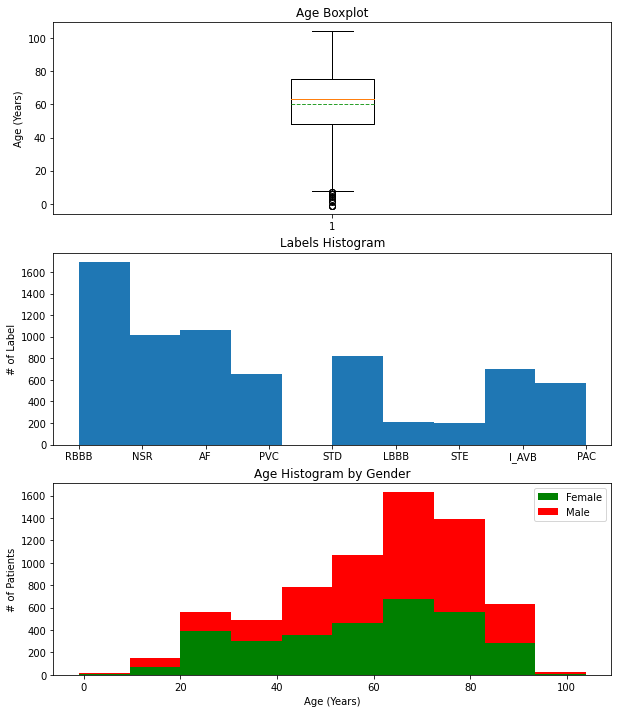

In [54]:
# check if array contains NaNs 
ind_age = [i for i,a in enumerate(age) if not np.isnan(a)]
ind_sex = [i for i,s in enumerate(sex)  if not s=='[nan]']
ind_age = np.array(ind_age)
ind_sex = np.array(ind_sex)
# find common indice in age and sex
ind_sex_age = (set(ind_age)).union(set(ind_sex))
ind_sex_age = np.array(ind_sex_age)

#check sex for male and female
female_ind = [i for i,s in enumerate(sex) if s=='Female']
male_ind = [i for i,s in enumerate(sex) if s=='Male']

#todo: labels into healthy and sick and check for correlations with pps

#some plots
import matplotlib.pyplot as plt


plt.figure(figsize=[10,12])
plt.subplot(311)
plt.boxplot(age[ind_age], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(312)
plt.hist(labels)
plt.title('Labels Histogram')
plt.ylabel('# of Label')

plt.subplot(313)
plt.hist(x = [ [age[i] for i in female_ind], [age[i] for i in male_ind] ], 
         stacked=True, color = ['g','r'],label = ['Female','Male'])
plt.title('Age Histogram by Gender')
plt.xlabel('Age (Years)')
plt.ylabel('# of Patients')
plt.legend()


Let's now check the data for NaNs and outliers..

Let's check the data for distributions and correlations

1490
166
8926
992


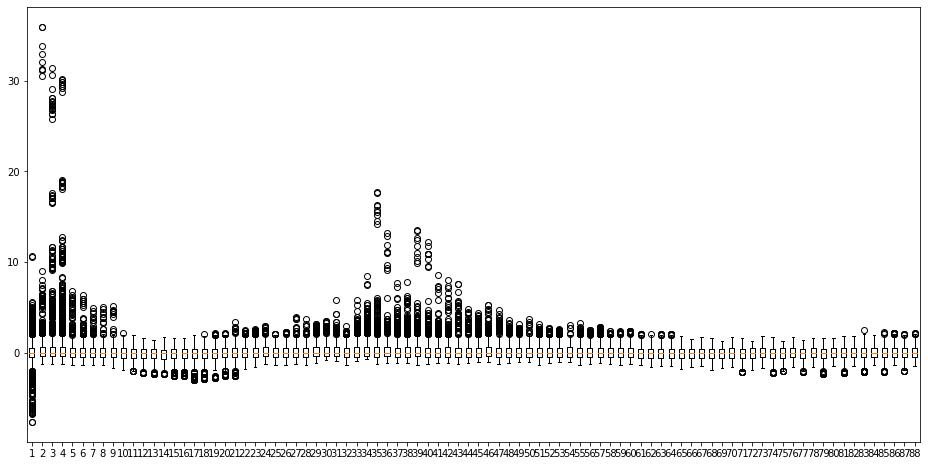

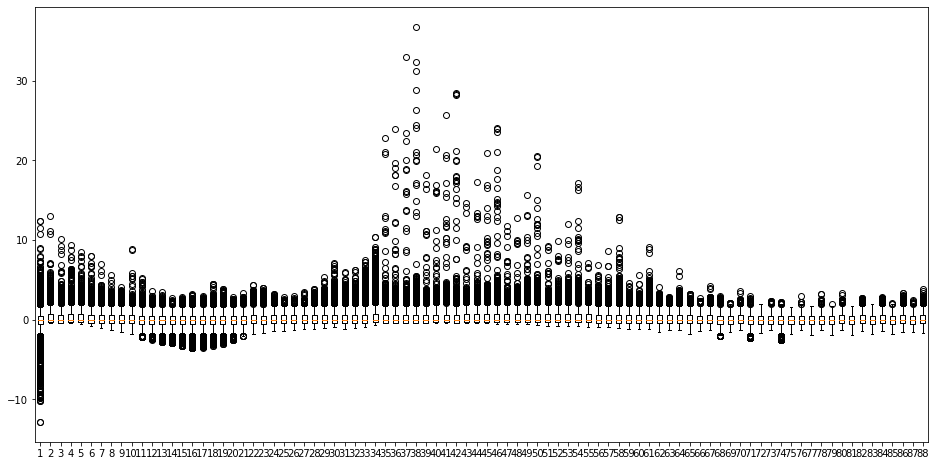

In [55]:
from sklearn.preprocessing import RobustScaler
# check features for outliers
cardisio_measurements = np.array(cardisio_measurements)
chinese_measurements = np.array(chinese_measurements)

trans = RobustScaler()
trans.fit(cardisio_measurements)
cardisio_measurements = trans.transform(cardisio_measurements)
f, ax = plt.subplots(figsize=(16, 8))
fig = plt.boxplot(cardisio_measurements)

trans = RobustScaler()
trans.fit(chinese_measurements)
chinese_measurements = trans.transform(chinese_measurements)
f, ax = plt.subplots(figsize=(16, 8))
fig = plt.boxplot(chinese_measurements)


# check features for outliers
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(cardisio_measurements)
print(np.count_nonzero(yhat==1))
print(np.count_nonzero(yhat==-1))

cardisio_measurements = cardisio_measurements[yhat != -1,:]


yhat = iso.fit_predict(chinese_measurements)
print(np.count_nonzero(yhat==1))
print(np.count_nonzero(yhat==-1))

chinese_measurements = chinese_measurements[yhat != -1,:]



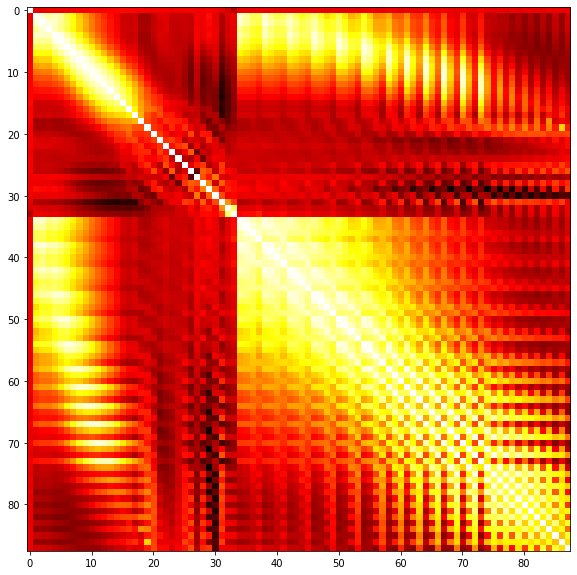

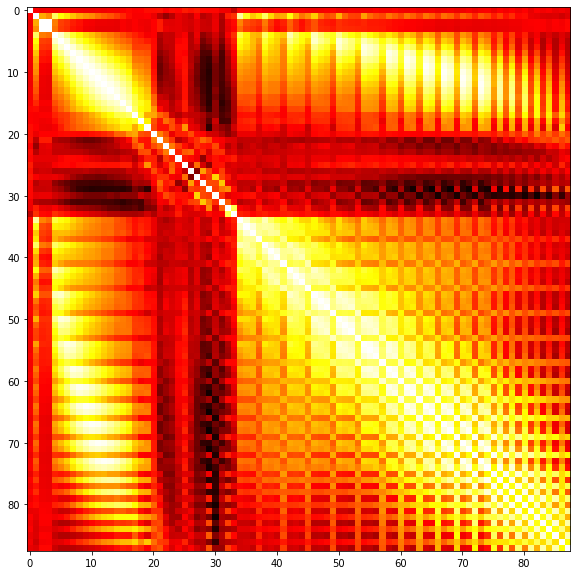

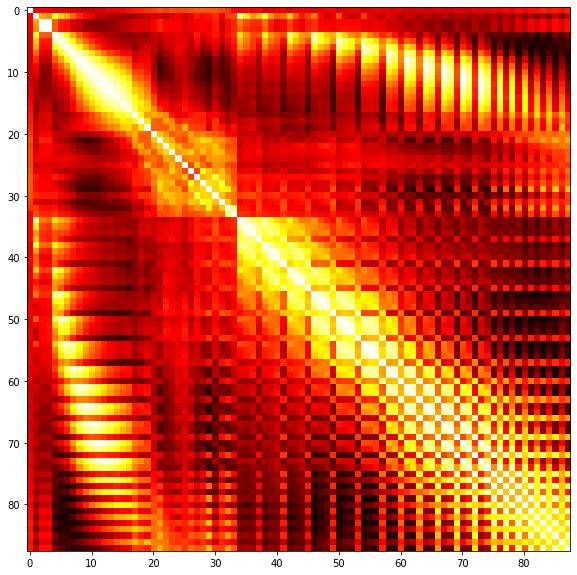

In [58]:
#smote oversampling 
import seaborn as sns

#get correlations of each features in dataset
corrmat = np.corrcoef(np.transpose(chinese_measurements))
fig = plt.figure(figsize=(10,10))
#plot heat map
img = plt.imshow(corrmat, cmap='hot')
plt.show()
#plt.colorbar(fig)

#get correlations of each features in dataset
corrmat = np.corrcoef(np.transpose(cardisio_measurements))
fig = plt.figure(figsize=(10,10))
#plot heat map
img = plt.imshow(corrmat, cmap='hot')
plt.show()
#plt.colorbar(fig)





#dim reduction? check for correlations and also feature selection 
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(np.transpose(cardisio_measurements))
cardisio_measurements_pca = pca.transform(np.transpose(cardisio_measurements))

corrmat = np.corrcoef((cardisio_measurements_pca))
plt.figure(figsize=(10,10))
#plot heat map
plt.imshow(corrmat, cmap='hot')
plt.show()



#f, ax = plt.subplots(figsize=(16, 8))
#fig = plt.boxplot(chinese_measurements)
#check features for correlations with personal parameters


#graph individual features by survival
#fig, saxis = plt.subplots(2, 3,figsize=(16,12))

#sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
#sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
#sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

#sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
#sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
#sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

In [57]:
#pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

NameError: ignored